# Tutorial: Comparison of Concrete-ML Regressors

In this tutorial, we will compare the performance of different **Concrete-ML** regressors with scikit-learn regressors. Concrete-ML regressors have an API that is very similar to scikit-learn regressors, with two additional elements:

* compiling the model to FHE
* predicting in FHE

To test FHE regressors, we can use the Virtual Library, a simulated FHE environment that is much faster than running in FHE. Although it does not operate over encrypted data, it is useful to design and train FHE-compatible regressors, as it allows the user to investigate whether the FHE constraints are met at design time

### FHE runtime considerations and simulation

In this demo the test data is classified in FHE and the decision function values for the domain
grid are computed using simulation, using the Virtual Library. Thus:

* the R2 score reported is computed in FHE

Due to the high runtimes in FHE, running the entire process in simulation is an option that can be activated by setting the argument fhe="simulate" when calling predict method.

This notebook is the regressor version of the following tutorial : [Tutorial: Comparison of Concrete-ML Classifier](https://github.com/zama-ai/concrete-ml)

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


import time
from functools import partial
import torch 

import matplotlib.pyplot as plt
import numpy as np

from concrete.ml.sklearn import (
    DecisionTreeRegressor,
    LinearSVR,
    LinearRegression,
    NeuralNetRegressor,
    RandomForestRegressor,
    XGBRegressor,
)

from concrete.numpy.compilation.configuration import Configuration


# from sklearn.linear_model import LinearRegression as skLinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neural_network import MLPRegressor
import random 

from IPython.display import clear_output
%matplotlib inline

rng = np.random.RandomState(42)

/home/ubuntulinux/miniconda3/envs/concrete_ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# The Virtual Library allows to simulate FHE executions without paying the cost of FHE
# computations. However, data is not encrypted when using the Virtual Library, the model executes
# an integer model on data in the clear.
ALWAYS_USE_VL = False

# Initialize the configuration used for Virtual Library tests only.
COMPIL_CONFIG_VL = Configuration(
    dump_artifacts_on_unexpected_failures=False,
    enable_unsafe_features=True,
)

In [3]:
def make_regression_data(n_samples=200, n_features=1, bias=0.0, noise_scale=1.0, loc=0.0, scale=1.0, polynomial_exp=1, target_scale=1.0, feature_scale = 1.0):
    """
    Generates a dataset for regression models.
    """
    X = rng.randn(n_samples, n_features)
    # To avoid to have to big numbers on polynomial datasets
    if polynomial_exp > 1:
        feature_scale = 1
    X = feature_scale * np.sort(X,0)
    scale = scale * polynomial_exp
    noise = noise_scale * rng.normal(loc=loc, scale=scale, size=n_samples)
    y = X.ravel()**polynomial_exp + bias + noise
    y *= target_scale
    return X, y

### Prerequisites
Before diving deep into the topic, it's important to review some prerequisites.

Quantization is a technique that discretizes continuous data, such as floating point numbers, into a fixed range of integers. This process may result in some loss of information, but a larger integer range can reduce the error, making it acceptable in some cases.

To learn more about quantization, you can refer to this [page](https://docs.zama.ai/concrete-ml/advanced-topics/quantization).

In the context of FHE, input data must be represented exclusively as integers, requiring the use of quantization. As a result:
* For linear models, quantization is performed after training by finding the best integer weight representations based on input and weight distribution. Users can manually set the n_bits parameter. Linear FHE models can handle large integers up to 50 bits, enabling quantization of inputs and weights over many bits (e.g., 16) while handling datasets with many features (e.g., 1000). Thus, they typically exhibit minimal loss, resulting in similar performance scores (e.g., R2 score) to float and quantized models.

* For tree-based models, both training and test data are quantized. A maximum accumulator bit-width of n+1 bits is needed for models trained with n_bits=n. A value of 5 or 6 bits gives the same accuracy as training in floating point, while values above 7 do not increase model performance and cause slowdowns.

* Built-in neural networks use several linear layers and Quantization Aware Training. The maximum accumulator bit-width is controlled by the number of weights and activation bits, as well as a pruning factor. This factor is automatically determined based on the desired accumulator bit-width and a multiplier factor can be optionally specified.

To learn more about the relationship between the maximum bit-width reached within a model, the bits of quantization used, and the number of features in the dataset, please refer to this [page](https://docs.preprod.zama.ai/concrete-ml/main/advanced-topics/pruning.html?highlight=formula#pruning-in-practice).

### Regression model with Concrete-ML

The development flow for a Concrete-ML  Regressions model includes the following steps:

- The model is trained on plaintext data, as only FHE inference is supported.

- Depending on the model type, quantization is performed with the associated scheme. The available quantization schemes can be found at the bottom of the notebook.

- The quantized model is compiled into an FHE equivalent using three steps: creating an executable operation graph, checking that the graph is FHE-compatible by verifying the maximum bit-width required for executing the model, and determining the cryptographic parameters to generate the secret and evaluation keys. If the compilation process fails due to the lack of parameters, the user can lower the value of n_bits for linear models or decrease the number of features in the dataset (using techniques such as PCA) and repeat the development flow.

- Inference can be performed on encrypted data.

In [5]:
def make_regressor_comparison(title, regressors,**kwargs):

    # Create subplots where each column represents a polynomial degree
    subplot_col = kwargs.get("polynomial_exp",1)
    fig, axs = plt.subplots(len(regressors), subplot_col, figsize=(15, 8),sharex=False)

    # Create datasets for each polynomial degree
    for i in range(subplot_col):
        kwargs_copy = kwargs.copy() 
        kwargs_copy['polynomial_exp'] = i + 1 
        X, y = make_regression_data(**kwargs_copy)
        
        # Split the data into training and test sets
        # Use 15 percent (30 points for a dataset of 200 points) for prediction
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

        sort_test_index = np.argsort(X_test.ravel()) 
        X_test = X_test[sort_test_index,:]
        y_test = y_test[sort_test_index]

        # Feature preprocessing
         # Linear models require polynomial features to be applied before training to fit a non-linear model and other models perform better with this transoformation
        pipe = Pipeline([("poly", PolynomialFeatures(i+1)),
                                ("scaler", StandardScaler()),])
                                
        X_poly_train = pipe.fit_transform(X_train)
        X_poly_test = pipe.transform(X_test)

        # Iterate over the given regressors
        for j, (regressor, model_name) in enumerate(regressors):
            if np.ndim(axs) > 1:
                axs[0,i].set_title("Polynomial degree {}".format(i+1))
                ax = axs[j,i] 
            else:
                try:
                    axs[i].set_title("Polynomial degree {}".format(i+1))
                    ax = axs[i]
                except:
                    ax = axs
                    ax.set_title("Polynomial degree {}".format(i+1))

            # Plot the training points
            ax.scatter(
                X_train,
                y_train,
                edgecolors="k",
                label="Train data",
            )

            # Plot the testing points
            ax.scatter(
                X_test,
                y_test,
                marker="D",
                alpha=0.6,
                edgecolors="k",
                label="Test data",
            )

            # Instantiate the model
            model = regressor()
            
            # Train the model and retrieve both the Concrete-ML model and its equivalent one from
            # scikit-learn
            # If the model is a NeuralNetClassifier, instantiate a scikit-learn MLPClassifier
            # separately in order to be able to be able to compare the results with a float model
            # that doesn't use QAT
            if model.__class__ == NeuralNetRegressor:

                sklearn_model = MLPRegressor(alpha=1, activation = "identity", max_iter=1000, hidden_layer_sizes=(25,),learning_rate_init=0.005)
                sklearn_model.fit(X_poly_train, y_train)

                # When we apply PolynomialFeatures the input dim is equal to degree of polynome + 1
                model.module__input_dim = i+2
                concrete_model = model.fit(X_poly_train, y_train.reshape(-1,1))

            else:

                concrete_model, sklearn_model = model.fit_benchmark(X_poly_train, y_train)   

            # Compute the predictions in clear using the scikit-learn model
            sklearn_y_pred = sklearn_model.predict(X_poly_test)    
            
            #Compile the Contrete-ML model
            circuit = concrete_model.compile(
                X_poly_train,
                configuration = COMPIL_CONFIG_VL if ALWAYS_USE_VL else None,
        
            )

            # If the prediction are done in FHE, generate the key
            if not ALWAYS_USE_VL:

                print(
                    "Generating a key for a "
                    f"{circuit.graph.maximum_integer_bit_width()}-bit circuit"
                )

                time_begin = time.time()
                circuit.client.keygen(force=False)
                time_end = time.time()
                print(f"Key generation time: {time_end - time_begin:.2f} seconds")

            # Compute the predictions in FHE using the Concrete-ML model
            # since we compiled with use_virtual_lib=True
            time_begin = time.time()
            concrete_y_pred = concrete_model.predict(X_poly_test, fhe="simulate")
            time_end = time.time()
            
            print(
                f"Execution time: {(time_end - time_begin) / len(X_test):.2f} "
                "seconds per sample"
            )

            # Measure the R2 score 
            sklearn_score = r2_score(sklearn_y_pred, y_test)
            concrete_score = r2_score(concrete_y_pred, y_test)

            is_a_tree_based_model = concrete_model.__class__ in [
                DecisionTreeRegressor,
                RandomForestRegressor,
                XGBRegressor,
            ]

            # If the model is not a tree-based model, retrieve the maximum integer bitwidth
            # reached within its circuit.
            bitwidth = None
            if not is_a_tree_based_model:
                bitwidth = circuit.graph.maximum_integer_bit_width()

            # Plot the predictions
            ax.plot(X_test, 
                    concrete_y_pred, 
                    c = 'blue',
                    linewidth = 2.5,
                    label =  'Concrete-ML')

            # Plot the predictions
            ax.plot(X_test, 
                    sklearn_y_pred, 
                    c = 'red',
                    linewidth = 2.5,
                    label =  'scikit-learn')

            ax.text(
                0.5,
                0.80,
                f"Concrete-ML R2: {concrete_score:.2f}\n scikit-learn R2: {sklearn_score:.2f}\n",
                transform = ax.transAxes,
                fontsize = 12,
                va = 'top',
                ha = 'right',
            )
            if bitwidth:
                ax.text(
                    0.75,
                    0.1,
                    f'bitwidth={bitwidth}',
                    transform = ax.transAxes,
                    fontsize = 12,
                    va = 'bottom',
                    ha = 'left'
                )
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper left')
            
            scaler = 0.5
            if len(regressors)==3:
                scaler = 0.3
            fig.text(-0.05, 0.75 - j*scaler, f"{model_name}", ha='center', va='bottom', fontsize=14)  
   
    clear_output(wait=True)

    plt.tight_layout(pad=1.2)
    plt.show()


#### Neural-net-based regressor
Runtime Warning: Despite the use of Virtual Lib, the runtimes for NeuralNet took approximately 2 hour.

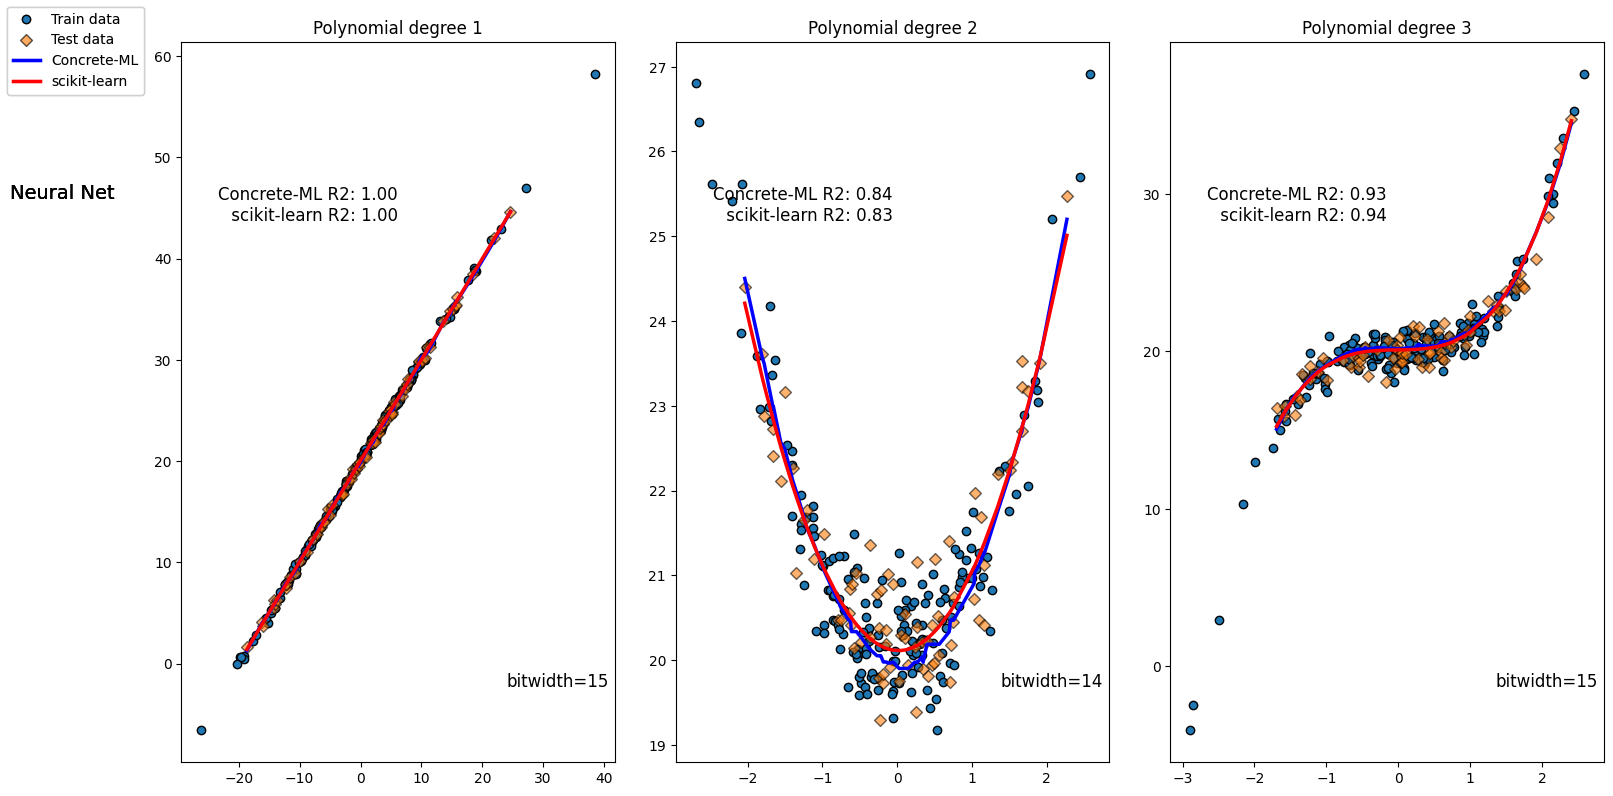

In [6]:

params_neural_net = {
    "module__n_w_bits": 6,
    "module__n_a_bits": 8,
    "module__n_accum_bits": 16,
    "module__n_hidden_neurons_multiplier": 10,
    "module__n_layers": 2,  # 1 hidden layer
    "module__activation_function": torch.nn.Identity,
    "max_epochs": 400,
    "verbose": 0,
    "lr": 0.1,
}


neural_network_regressor = [
    (
        partial(NeuralNetRegressor, batch_size=32, **params_neural_net),
        "Neural Net",
    ),
]
make_regressor_comparison("NN Regressors",neural_network_regressor, n_samples = 250, polynomial_exp=3, bias=20,scale=0.25, target_scale=1, feature_scale = 10)

#### Linear regressor

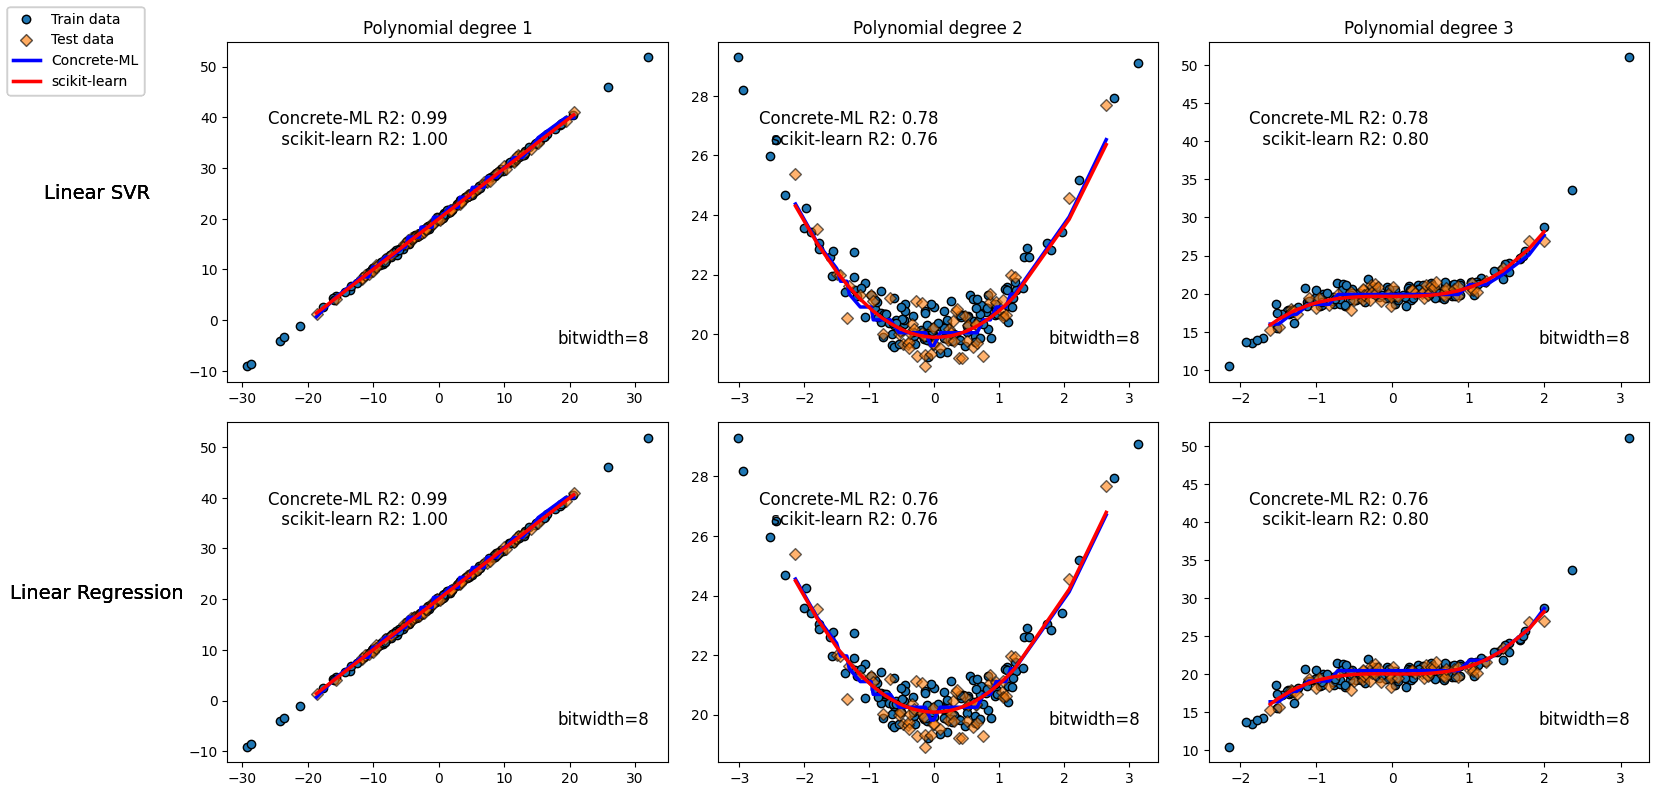

In [7]:
np.random.seed(42)
linear_regressor = [
    (partial(LinearSVR, n_bits={"op_inputs": 5, "op_weights": 2}, C=0.5), "Linear SVR"),
    (partial(LinearRegression, n_bits={"op_inputs": 5, "op_weights": 2}), "Linear Regression"),
]
make_regressor_comparison("linear",linear_regressor, polynomial_exp=3, bias=20,scale=0.25, target_scale=1, feature_scale = 10)

### Tree and tree ensemble classifiers
Runtime Warning: Despite the use of Virtual Lib, the runtimes for the next three regressors took approximately 1 hour. In particular, the XGBRegressor took 28 seconds per sample on the Polynomial Degree 3 dataset.

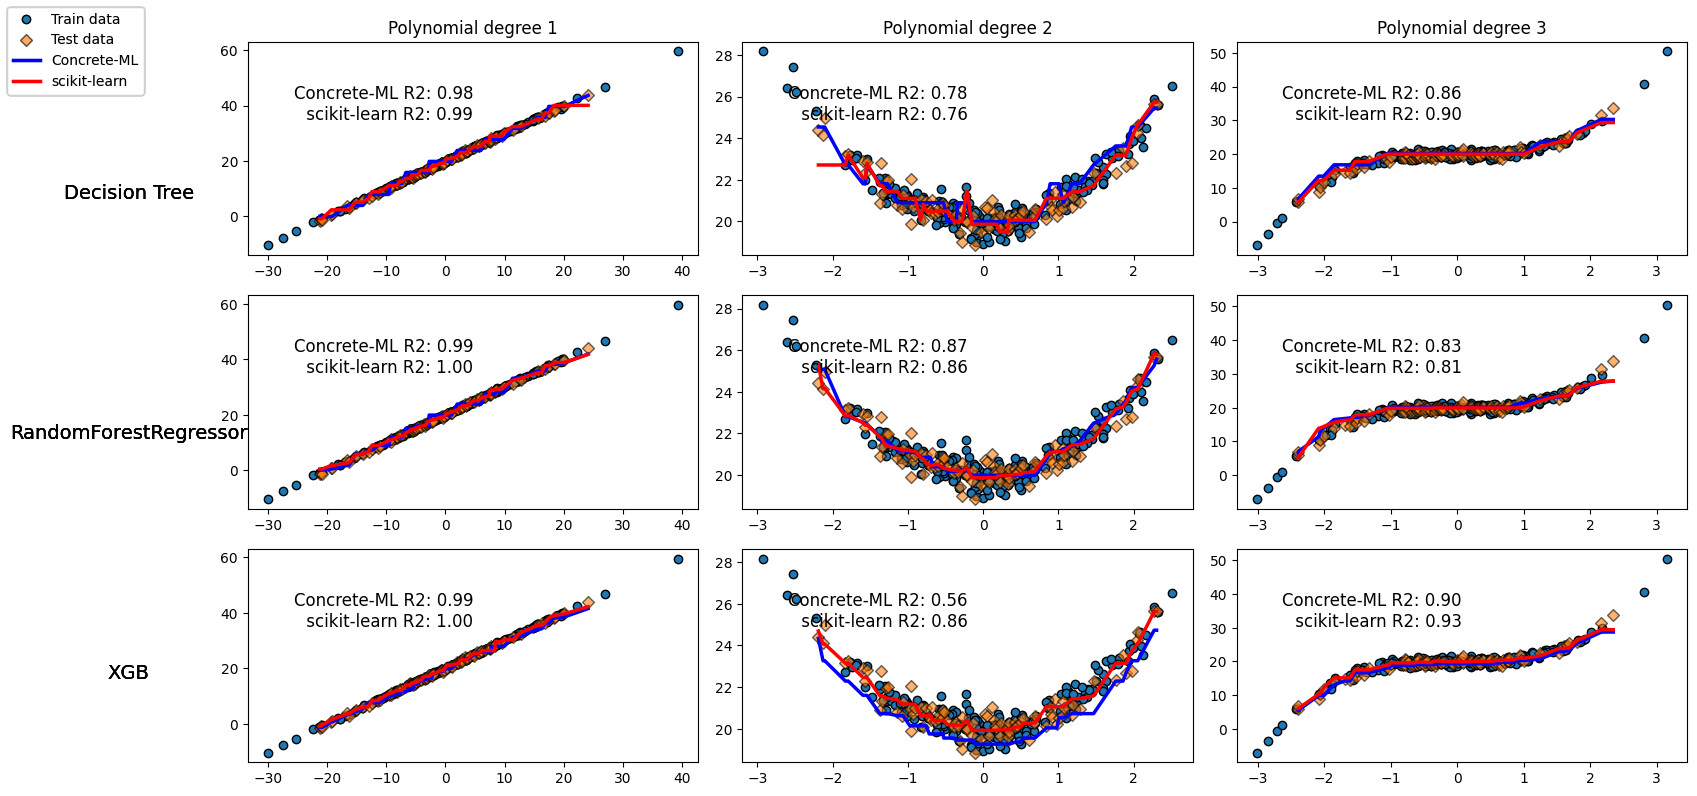

In [8]:
tree_regressors = [
    (partial(DecisionTreeRegressor, n_bits=5,max_depth=5), "Decision Tree"),
    (partial(RandomForestRegressor, n_bits=5), "RandomForestRegressor"),
    (partial(XGBRegressor, n_bits = 6, n_estimators = 50, max_depth = 3, gamma = 1, learning_rate =0.3), "XGB"),
]

make_regressor_comparison("Tree-Based Regressors", tree_regressors, n_samples = 300, polynomial_exp = 3, bias=20,scale=0.25, target_scale=1, feature_scale = 10)
     

# Conclusion:

In this tutorial, we compared the performance of different linear regression models using Concrete-ML and scikit-learn libraries in Python. The purpose of this tutorial was to show the effectiveness of linear regression models in Fully Homomorphic Encryption (FHE) and to provide a comparison between the different models.

We evaluated using R2 score three types of linear regression models: 
* linear (Support Vector Regressor, Linear Regression)
* neural-networks (multi-layer non-linear models)
* tree-based (Decision Tree, Random Forest, XGBoost)

The R2 score of the Concrete regressors is measured on encrypted data. These regressors work with parameters and inputs that are heavily quantized and, thus, show R2 score loss (especially in XBGRegressor):

* linear regression models: linear regression models in FHE have good performance and are fast. These models are accurate as they require very little quantization. Their performance is almost identical to that of their fp32 counterparts

* tree-based regression models: Tree-based regression models achieve good R2 score on encrypted data in both fp32 and quantized mode in FHE, thanks to their unique computations. In fact, using a random forest model on a polynomial of degree 3 can even improve their performance further. However, XGBRegressor is an exception as its performance is not as good in quantized mode compared to fp32 This is because the best parameters for XGBRegressor were identified for fp32 models and were applied to the quantized version, resulting in lower R2 score.

* neural network regressors: as seen above, neural network regressors have good performance in FHE despite being subjected to heavy quantization thanks to Quantization Aware Training (QAT) techniques

One way to reduce the performance gap between FHE and their fp32 counterparts for complex models like neural networks or XGBRegressor, which require more hyperparameter optimization work, is to use the GridSearch method separately on both FHE and fp32 models instead of using the ".fit_benchmark" method, which forces the use of the same hyperparameters on both models. For an example of the use of GridSearch in the context of Concrete-ml, please refer to this (page)[https://github.com/zama-ai/concrete-ml/blob/release/0.6.x/docs/advanced_examples/LinearRegression.ipynb]

It should be noted that the number of samples is relatively low for runtime purposes, especially for tree-based models and neural networks, where feature engineering was not performed.

Refer to [Classifier version of this notebook](https://github.com/zama-ai/concrete-ml)